In [ ]:
import tensorflow as tf
import os
from os.path import isfile, join
import numpy as np
import shutil
from tensorflow import keras
from pathlib import Path
from IPython.display import display, Audio
import subprocess

In [ ]:
!cp -r "../content/drive/MyDrive/input/speaker-recognition-dataset" ./

In [ ]:
data_directory = "./speaker-recognition-dataset/16000_pcm_speeches"
audio_folder = "audio"
noise_folder = "noise"

audio_path = os.path.join(data_directory, audio_folder)
noise_path = os.path.join(data_directory, noise_folder)

In [ ]:
audio_path

'./speaker-recognition-dataset/16000_pcm_speeches/audio'

In [ ]:
valid_split = 0.1

shuffle_seed = 43

sample_rate = 16000

scale = 0.5

batch_size = 128

epochs = 15

In [ ]:
for folder in os.listdir(data_directory):
    if os.path.isdir(os.path.join(data_directory, folder)):
        if folder in [audio_folder, noise_folder]:

            continue
        elif folder in ["other", "_background_noise_"]:

            shutil.move(
                os.path.join(data_directory, folder),
                os.path.join(noise_path, folder),
            )
        else:
            shutil.move(
                os.path.join(data_directory, folder),
                os.path.join(audio_path, folder),
            )


In [ ]:
noise_paths = []
for subdir in os.listdir(noise_path):
    subdir_path = Path(noise_path) / subdir
    if os.path.isdir(subdir_path):
        noise_paths += [
            os.path.join(subdir_path, filepath)
            for filepath in os.listdir(subdir_path)
            if filepath.endswith(".wav")
        ]

In [ ]:
noise_paths

['speaker-recognition-dataset/16000_pcm_speeches/noise/_background_noise_/doing_the_dishes.wav',
 'speaker-recognition-dataset/16000_pcm_speeches/noise/_background_noise_/running_tap.wav',
 'speaker-recognition-dataset/16000_pcm_speeches/noise/_background_noise_/dude_miaowing.wav',
 'speaker-recognition-dataset/16000_pcm_speeches/noise/_background_noise_/10convert.com_Audience-Claps_daSG5fwdA7o.wav',
 'speaker-recognition-dataset/16000_pcm_speeches/noise/other/exercise_bike.wav',
 'speaker-recognition-dataset/16000_pcm_speeches/noise/other/pink_noise.wav']

In [ ]:
command = (
    "for dir in `ls -1 " + noise_path + "`; do "
    "for file in `ls -1 " + noise_path + "/$dir/*.wav`; do "
    "sample_rate=`ffprobe -hide_banner -loglevel panic -show_streams "
    "$file | grep sample_rate | cut -f2 -d=`; "
    "if [ $sample_rate -ne 16000 ]; then "
    "ffmpeg -hide_banner -loglevel panic -y "
    "-i $file -ar 16000 temp.wav; "
    "mv temp.wav $file; "
    "fi; done; done"
)

In [ ]:
os.system(command)
def load_noise_sample(path):
    sample, sampling_rate = tf.audio.decode_wav(
        tf.io.read_file(path), desired_channels=1
    )
    if sampling_rate == sample_rate:
        slices = int(sample.shape[0] / sample_rate)
        sample = tf.split(sample[: slices * sample_rate], slices)
        return sample
    else:
        print("Sampling rate for",path, "is incorrect")
        return None


noises = []
for path in noise_paths:
    sample = load_noise_sample(path)
    if sample:
        noises.extend(sample)
noises = tf.stack(noises)

In [ ]:
def paths_and_labels_to_dataset(audio_paths, labels):
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda x: path_to_audio(x))
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))

In [ ]:
def path_to_audio(path):
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, sample_rate)
    return audio

In [ ]:
def add_noise(audio, noises=None, scale=0.5):
    if noises is not None:
        tf_rnd = tf.random.uniform(
            (tf.shape(audio)[0],), 0, noises.shape[0], dtype=tf.int32
        )
        noise = tf.gather(noises, tf_rnd, axis=0)

        prop = tf.math.reduce_max(audio, axis=1) / tf.math.reduce_max(noise, axis=1)
        prop = tf.repeat(tf.expand_dims(prop, axis=1), tf.shape(audio)[1], axis=1)

        audio = audio + noise * prop * scale

    return audio

In [ ]:
def audio_to_fft(audio):
    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)

    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])

In [ ]:
class_names = os.listdir(audio_path)
print(class_names,)

audio_paths = []
labels = []
for label, name in enumerate(class_names):
    print("Speaker:",(name))
    dir_path = Path(audio_path) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    audio_paths += speaker_sample_paths
    labels += [label] * len(speaker_sample_paths)

['Julia_Gillard', 'Benjamin_Netanyau', 'Nelson_Mandela', 'Jens_Stoltenberg', 'Magaret_Tarcher']
Speaker: Julia_Gillard
Speaker: Benjamin_Netanyau
Speaker: Nelson_Mandela
Speaker: Jens_Stoltenberg
Speaker: Magaret_Tarcher


In [ ]:
# Shuffle to generate random data
rng = np.random.RandomState(shuffle_seed)
rng.shuffle(audio_paths)
rng = np.random.RandomState(shuffle_seed)
rng.shuffle(labels)

In [ ]:
# Split into training and validation
num_val_samples = int(valid_split * len(audio_paths))
train_audio_paths = audio_paths[:-num_val_samples]
train_labels = labels[:-num_val_samples]


valid_audio_paths = audio_paths[-num_val_samples:]
valid_labels = labels[-num_val_samples:]

In [ ]:
# Create datasets, one for training and the other for validation
train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=batch_size * 8, seed=shuffle_seed).batch(
    batch_size
)

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=shuffle_seed).batch(32)

In [ ]:
# Add noise to the training set
train_ds = train_ds.map(
    lambda x, y: (add_noise(x, noises, scale=scale), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)

# Transform audio wave to the frequency domain using `audio_to_fft`
train_ds = train_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE
)

train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

valid_ds = valid_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE
)
valid_ds = valid_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
from tensorflow.keras.layers import Conv1D

In [ ]:
#building min max CNN

def residual_block(x, filters, conv_num = 3, activation = "relu"):
    s = keras.layers.Conv1D(filters, 1, padding = "same")(x)

    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding = "same")(x)
        x = keras.layers.Activation(activation)(x)

    x = keras.layers.Conv1D(filters, 3, padding = "same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)

    return keras.layers.MaxPool1D(pool_size = 2, strides = 2)(x)

def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape = input_shape, name = "input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(inputs, 32, 2)
    x = residual_block(inputs, 64, 3)
    x = residual_block(inputs, 128, 3)
    x = residual_block(inputs, 128, 3)
    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation = "softmax", name = "output")(x)

    return keras.models.Model(inputs = inputs, outputs = outputs)

model = build_model((sample_rate // 2, 1), len(class_names))

model.summary()

model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model_save_filename = "model.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(model_save_filename, monitor="val_accuracy", save_best_only=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 8000, 1)]    0           []                               
                                                                                                  
 conv1d_15 (Conv1D)             (None, 8000, 128)    512         ['input[0][0]']                  
                                                                                                  
 activation_10 (Activation)     (None, 8000, 128)    0           ['conv1d_15[0][0]']              
                                                                                                  
 conv1d_16 (Conv1D)             (None, 8000, 128)    49280       ['activation_10[0][0]']          
                                                                                              

In [ ]:
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
)

Epoch 1/15
53/53 [==============================] - 1118s 21s/step - loss: 21.0142 - accuracy: 0.5378 - val_loss: 0.4602 - val_accuracy: 0.8467
Epoch 2/15
53/53 [==============================] - 1074s 20s/step - loss: 0.2586 - accuracy: 0.9101 - val_loss: 0.3183 - val_accuracy: 0.8907
Epoch 3/15
53/53 [==============================] - 1071s 20s/step - loss: 0.1344 - accuracy: 0.9511 - val_loss: 0.1050 - val_accuracy: 0.9613
Epoch 4/15
53/53 [==============================] - 1072s 20s/step - loss: 0.1066 - accuracy: 0.9600 - val_loss: 0.1110 - val_accuracy: 0.9560
Epoch 5/15
53/53 [==============================] - 1074s 20s/step - loss: 0.1354 - accuracy: 0.9519 - val_loss: 0.1294 - val_accuracy: 0.9560
Epoch 6/15
53/53 [==============================] - 1107s 21s/step - loss: 0.1037 - accuracy: 0.9637 - val_loss: 0.0849 - val_accuracy: 0.9720
Epoch 7/15
53/53 [==============================] - 1065s 20s/step - loss: 0.0789 - accuracy: 0.9719 - val_loss: 0.0641 - val_accuracy: 0.978

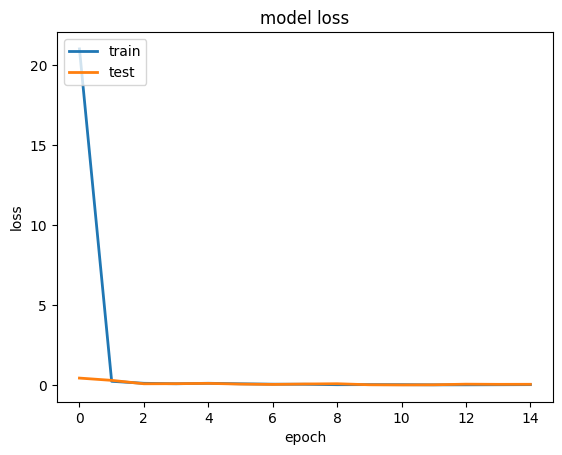

In [ ]:
plt.plot(history.history['loss'], linewidth=2)
plt.plot(history.history['val_loss'], linewidth=2)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

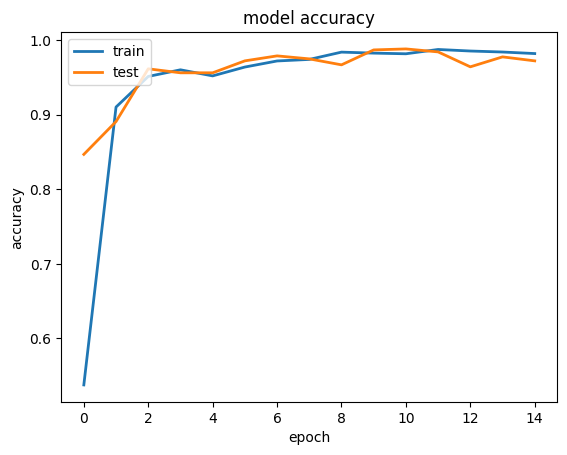

In [ ]:
 #summarize history for accuracy
plt.plot(history.history['accuracy'], linewidth=2)
plt.plot(history.history['val_accuracy'], linewidth=2)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
print("Accuracy of model:",model.evaluate(valid_ds))

24/24 [==============================] - 37s 1s/step - loss: 0.0723 - accuracy: 0.9720
Accuracy of model: [0.07228361070156097, 0.972000002861023]


In [ ]:
SAMPLES_TO_DISPLAY = 10

test_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
test_ds = test_ds.shuffle(buffer_size=batch_size * 8, seed=shuffle_seed).batch(
    batch_size
)

test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=scale), y))

for audios, labels in test_ds.take(1):
    ffts = audio_to_fft(audios)
    y_pred = model.predict(ffts)
    rnd = np.random.randint(0, batch_size, SAMPLES_TO_DISPLAY)
    audios = audios.numpy()[rnd, :, :]
    labels = labels.numpy()[rnd]
    y_pred = np.argmax(y_pred, axis=-1)[rnd]

    for index in range(SAMPLES_TO_DISPLAY):
        print(
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[labels[index]],
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[y_pred[index]],
            )
        )
        if labels[index] ==y_pred[index]:
            print("Welcome")
        else:
            print("Sorry")
        print("The speaker is" if labels[index] == y_pred[index] else "", class_names[y_pred[index]])

4/4 [==============================] - 5s 1s/step
Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau
Welcome
The speaker is Benjamin_Netanyau
Speaker: Julia_Gillard	Predicted: Julia_Gillard
Welcome
The speaker is Julia_Gillard
Speaker: Magaret_Tarcher	Predicted: Magaret_Tarcher
Welcome
The speaker is Magaret_Tarcher
Speaker: Julia_Gillard	Predicted: Julia_Gillard
Welcome
The speaker is Julia_Gillard
Speaker: Jens_Stoltenberg	Predicted: Nelson_Mandela
Sorry
 Nelson_Mandela
Speaker: Magaret_Tarcher	Predicted: Magaret_Tarcher
Welcome
The speaker is Magaret_Tarcher
Speaker: Nelson_Mandela	Predicted: Nelson_Mandela
Welcome
The speaker is Nelson_Mandela
Speaker: Magaret_Tarcher	Predicted: Magaret_Tarcher
Welcome
The speaker is Magaret_Tarcher
Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau
Welcome
The speaker is Benjamin_Netanyau
Speaker: Nelson_Mandela	Predicted: Nelson_Mandela
Welcome
The speaker is Nelson_Mandela


In [ ]:
def paths_to_dataset(audio_paths):
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    return tf.data.Dataset.zip((path_ds))

def predict(path, labels):
    test = paths_and_labels_to_dataset(path, labels)


    test = test.shuffle(buffer_size=batch_size * 8, seed=shuffle_seed).batch(
    batch_size
    )
    test = test.prefetch(tf.data.experimental.AUTOTUNE)


    test = test.map(lambda x, y: (add_noise(x, noises, scale=scale), y))

    for audios, labels in test.take(1):
        ffts = audio_to_fft(audios)
        y_pred = model.predict(ffts)
        rnd = np.random.randint(0, 1, 1)
        audios = audios.numpy()[rnd, :]
        labels = labels.numpy()[rnd]
        y_pred = np.argmax(y_pred, axis=-1)[rnd]

    for index in range(1):
            print(
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
            "[92m",y_pred[index],
                "[92m", y_pred[index]
                )
            )

            print("Speaker Predicted:",class_names[y_pred[index]])


In [ ]:
  path = ["../content/speaker-recognition-dataset/16000_pcm_speeches/audio/Nelson_Mandela/1029.wav"]
labels = ["unknown"]
try:
    predict(path, labels)
except:
    print("Error! Check if the file correctly passed or not!")

1/1 [==============================] - 0s 104ms/step
Speaker: 2	Predicted: 2
Speaker Predicted: Nelson_Mandela


In [ ]:
 path = ["/content/speaker-recognition-dataset/16000_pcm_speeches/audio/Julia_Gillard/1026.wav"]
labels = ["unknown"]
try:
    predict(path, labels)
except:
    print("Error! Check if the file correctly passed or not!")

1/1 [==============================] - 0s 93ms/step
Speaker: 0	Predicted: 0
Speaker Predicted: Julia_Gillard
